# MFT Anomaly Detection - Google Colab Notebook

In [1]:

!pip install pandas scikit-learn matplotlib seaborn


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


In [3]:

from google.colab import files

uploaded = files.upload()

# Load the MFT logs
mft_logs = pd.read_csv('mft_logs_sample.csv')
mft_logs.head()


Saving mft_logs_sample.csv to mft_logs_sample.csv


timestamp user_id   dest_ip  file_size_MB  transfer_time_sec
0  2025-04-01 08:00:00   user1  10.0.0.1        264.96              16.78
1  2025-04-01 09:00:00   user2  10.0.0.2         81.79              28.28
2  2025-04-01 10:00:00   user3  10.0.0.3        364.33              71.69
3  2025-04-01 11:00:00   user4  10.0.0.4        319.96              10.91
4  2025-04-01 12:00:00   user5  10.0.0.5         45.08             104.21

In [4]:

# Feature Engineering
mft_logs['hour_of_day'] = pd.to_datetime(mft_logs['timestamp']).dt.hour
mft_logs['unique_dest_ips'] = mft_logs.groupby('user_id')['dest_ip'].transform('nunique')

# Encode user ID
le = LabelEncoder()
mft_logs['user_id_encoded'] = le.fit_transform(mft_logs['user_id'])

# Normalize
scaler = MinMaxScaler()
mft_logs[['file_size_MB', 'transfer_time_sec', 'unique_dest_ips']] = scaler.fit_transform(
    mft_logs[['file_size_MB', 'transfer_time_sec', 'unique_dest_ips']]
)

# Add labels for known anomaly patterns
mft_logs['label'] = np.where(
    (mft_logs['file_size_MB'] > 0.8) & (mft_logs['transfer_time_sec'] < 0.2),
    1, 0
)

mft_logs.to_csv("sample_mft_logs_normalized.csv", index=False)
mft_logs.head()


timestamp user_id   dest_ip  file_size_MB  transfer_time_sec  \
0  2025-04-01 08:00:00   user1  10.0.0.1      0.500478           0.062915   
1  2025-04-01 09:00:00   user2  10.0.0.2      0.083557           0.186174   
2  2025-04-01 10:00:00   user3  10.0.0.3      0.726658           0.651447   
3  2025-04-01 11:00:00   user4  10.0.0.4      0.625666           0.000000   
4  2025-04-01 12:00:00   user5  10.0.0.5      0.000000           1.000000   

   hour_of_day  unique_dest_ips  user_id_encoded  label  
0            8              0.0                0      0  
1            9              0.0                2      0  
2           10              0.0                3      0  
3           11              0.0                4      0  
4           12              0.0                5      0

In [5]:

X = mft_logs[['file_size_MB', 'transfer_time_sec', 'hour_of_day', 'unique_dest_ips', 'user_id_encoded']]

model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X)

mft_logs['anomaly_score'] = model.decision_function(X)
mft_logs['anomaly'] = model.predict(X)


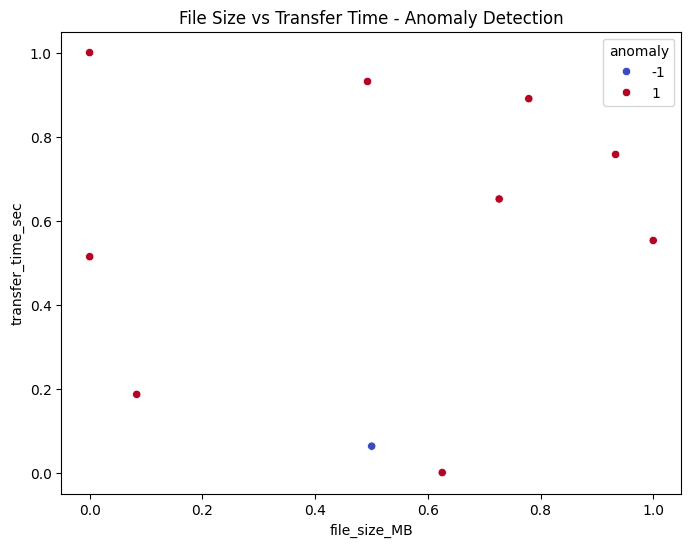

In [6]:

# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=mft_logs, x='file_size_MB', y='transfer_time_sec', hue='anomaly', palette='coolwarm')
plt.title('File Size vs Transfer Time - Anomaly Detection')
plt.savefig('anomaly_scatter_plot.png')
plt.show()


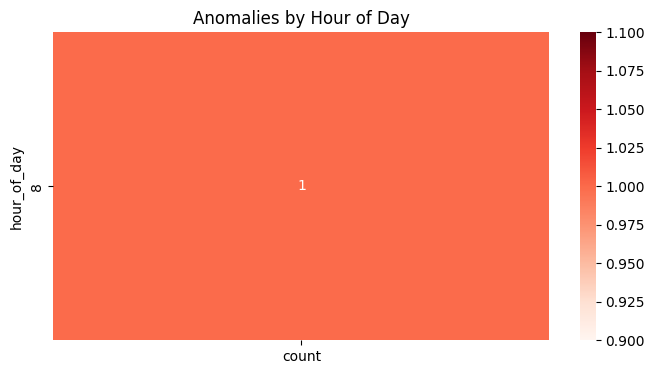

In [7]:

# Heatmap: Anomalies per Hour
heatmap_data = mft_logs[mft_logs['anomaly'] == -1].groupby('hour_of_day').size().reset_index(name='count')
heatmap = heatmap_data.pivot_table(index='hour_of_day', values='count', aggfunc='sum').fillna(0)
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap, annot=True, cmap='Reds', fmt='g')
plt.title("Anomalies by Hour of Day")
plt.savefig("anomaly_heatmap.png")
plt.show()
